# Méthodo 

## **Algorithm:**

1. Metadata elimination
    1. EDA to select 
    2. Meta data ... 
    Note : probablement OFF 
2. Encodings in DB of all images( using CNN ) 
    1. AE
    2. NN 
3. Compute Similarity Function
    1. Cosine ?? 
    2. Fisher vetor ?? 
4. Create graph (edges : images, nodes : similarity)
5. Apply Pagerank 

## Template Matching

- Template and query image
- Hypernetworks
- Padd network
- Create multiple patches data

In [1225]:
from pathlib import Path, PurePath
from typing import Dict, List, Optional, Union
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from imagededup.utils.data_generator import DataGenerator

import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications import MobileNetV2
from keras.models import Model
from IPython.display import Image

from keras import backend as K
from keras.layers import Dense, Activation,Conv2D, MaxPool2D, Flatten, Input, ZeroPadding2D
from keras.layers.merge import concatenate
from keras.utils import plot_model


from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import models
from keras.applications import imagenet_utils
from keras import metrics


from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input


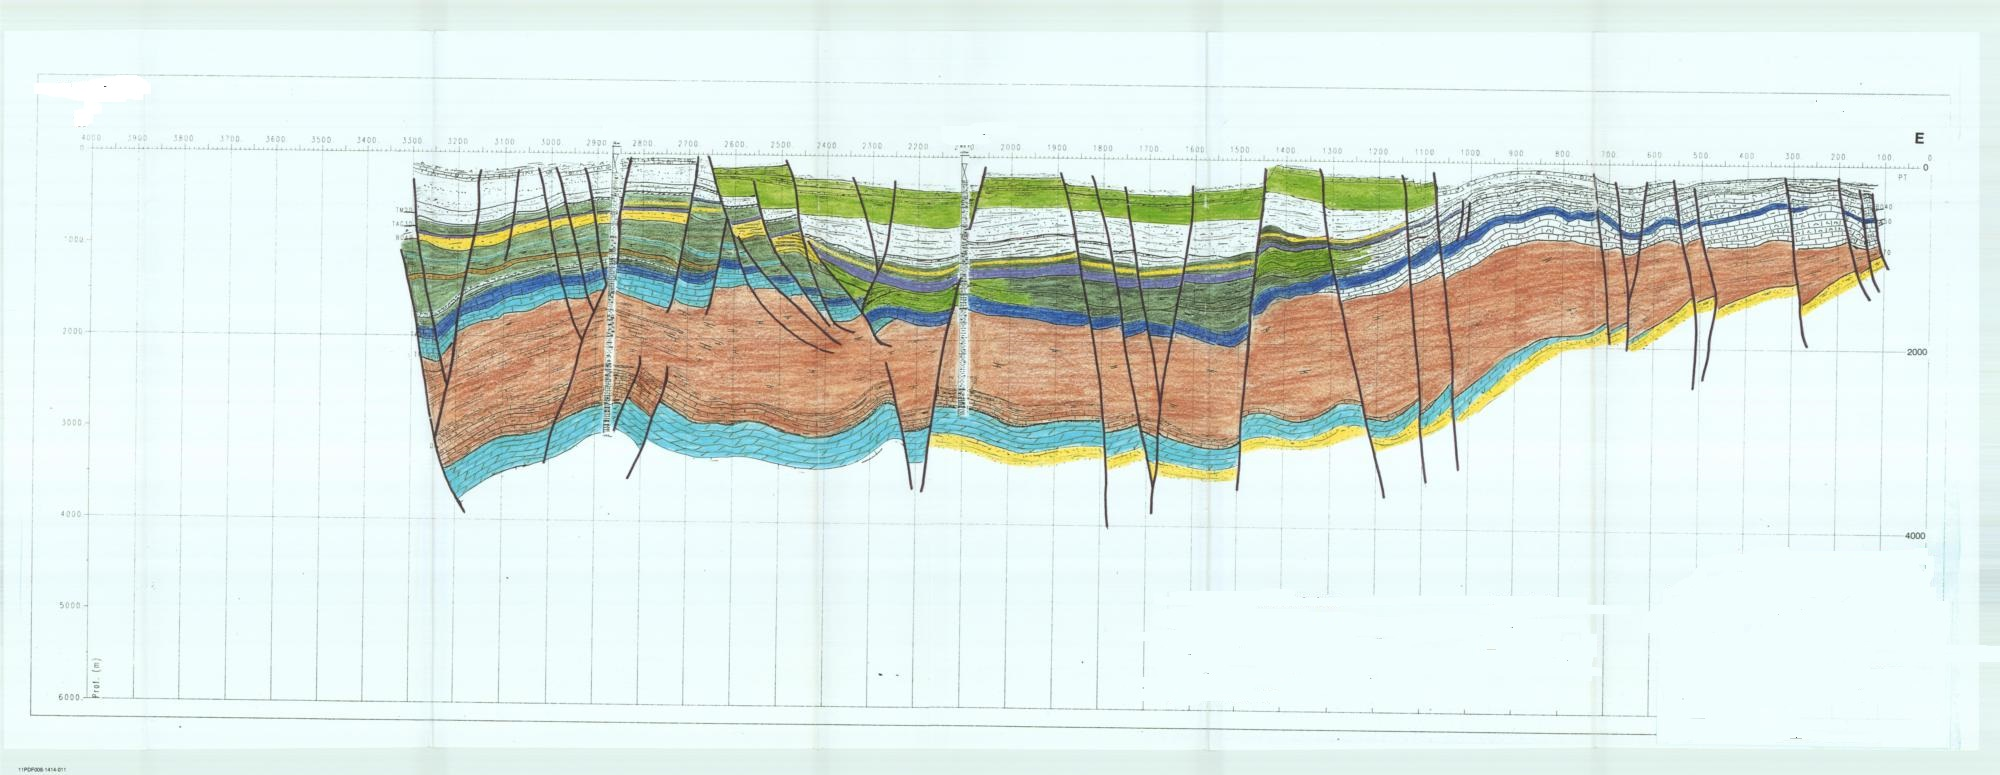

In [1226]:
test_image_path='../datasets/near_duplicates/00132.jpg'

# image vis

Image(filename=test_image_path)

In [1227]:
def prepare_image(path):
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded_dims =np.array([img_array]) 
    return preprocess_input(img_array_expanded_dims)


In [1228]:
base_model= MobileNet(weights='imagenet',include_top=False,pooling='avg') 
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

In [1229]:
image_model = prepare_image(test_image_path)
pred = base_model.predict(image_model)
pred_vec = pred.flatten()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [1230]:
## PRedicted vector is 1024
pred_vec.shape

(1024,)

## k -mean after encoding

In [1231]:
# Encod directory 

In [1232]:
import os 
dir_path ='../datasets/near_duplicates/'

In [1233]:
# BATch optim
def encoding_directory(dir_path):
    '''
    Returns a dict { filename, encoding} 
    '''    
    encoding_map ={}
    filenames = [dir for dir in os.listdir(dir_path)]
    for image_path in filenames : 
        image_model = prepare_image(dir_path+image_path)    
        pred = base_model.predict(image_model)
        pred_vec = pred.flatten()
        encoding_map[image_path] = pred_vec
    return encoding_map
    

In [1234]:
import pickle
filename ="output.pickle"
file_to_write = open(filename, "wb")
pickle.dump(encoding, file_to_write)
file_to_write.close()


## Apply k-means

In [1235]:
import pandas as pd

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)

In [1236]:
infile = open(filename,'rb')
new_dict = pickle.load(infile, encoding='bytes')

In [ ]:
df = pd.DataFrame.from_dict(new_dict,orient='index')
df = df.sort_index()
df.shape

In [ ]:
df.head()

In [ ]:
kmeans.fit(df)

In [ ]:
df['cluster'] =kmeans.labels_

In [ ]:
df.head()

# Direct similarity on cluster

In [ ]:
PATH ='00074.jpg'
DIRECTORY ='../datasets/near_duplicates/'
test_image_path=DIRECTORY+PATH

# image vis

Image(filename=test_image_path)

In [ ]:
def similarities(img_path,df,nb_similar=10):
    encoding = df.loc[img_path][:-1] # Feedforward NN 
    c = kmeans.predict(encoding.values.reshape(1,-1))    
    x = df[df['cluster']==c[0]].iloc[:,:-1]
    localSimilarity = {}
    l= list(x.index)
    l.remove(img_path)
    for img in l : 
        sim = 1- distance.cosine(x.loc[img], encoding)
        localSimilarity[img]= sim
        sort_localSim = sorted(localSimilarity.items(), key=lambda x: x[1], reverse=True)
    return sort_localSim[0:nb_similar]


In [ ]:
S = similarities(PATH,df)
S

# Evaluation

In [ ]:
# Similar pairs
pairs={}
for path in df.index:
    sim = similarities(path,df,nb_similar=10)
    dum =[name for name , score in sim if score >0.8]
    pairs[path] = dum   

In [ ]:
# MATCHING by list
diff ={}
for im in pairs.keys() :
    if len(pairs[im]) > 0 and len(duplicates[im]) > 0:
        matches = set(pairs[im])&set(duplicates[im])
        if len(set(pairs[im])&set(duplicates[im])) == 0: 
            diff[im]=(pairs[im],duplicates[im])            
            

In [ ]:
len(diff)

In [ ]:
# MATCHING by first
diff ={}
for im in pairs.keys() :
    if len(pairs[im]) > 0 and len(duplicates[im]) > 0:
        if pairs[im][0] != duplicates[im][0] : 
            diff[im]=(pairs[im],duplicates[im])            
            

In [ ]:
len(diff)

# PARTIE II : Template Matching

In [ ]:
## Model 

In [ ]:
base_model= MobileNetV2(weights='imagenet',include_top=False) 
base_model.trainable = False

inp1 = Input(shape=(224,224,3))
x1 = base_model(inp1)
inp2 = Input(shape=(224,224,3))
# Add paddinf
x2 = base_model(inp2)
x = concatenate([x1, x2])
# add layers
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu'²)(x) 
x=Dense(1024,activation='relu')(x) 
x=Dense(512,activation='relu')(x) 
output =Dense(1, activation='sigmoid')(x) #final layer with binaru activation

In [ ]:
model = Model([inp1,inp2],output)

In [1303]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    multiple             2257984     input_32[0][0]                   
                                                                 input_33[0][0]                   
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 7, 7, 2560)   0           mobilenetv2_1.00_224[1][0] 

In [ ]:
model.compile(optimizer='Adam',loss='binary_crossentropy',
              metrics=[metrics.BinaryCrossentropy(),metrics.AUC()])

## Prepare cropped data

In [ ]:
import tensorflow as tf
from tensorflow.image import random_crop

In [ ]:
# TODO Create class crop
def prepare_image_query(path):
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded_dims =np.array([img_array]) 
    return preprocess_input(img_array_expanded_dims)

def prepare_image_template(path):
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded_dims =np.array([img_array]) 
    return preprocess_input(img_array_expanded_dims)


def pad_image(img, desiredX=224, desiredY=224):
    shape = img.shape
    xDiff = desiredX - shape[0]
    xLeft = xDiff//2
    xRight = xDiff-xLeft

    yDiff = desiredY - shape[1]
    yLeft = yDiff//2
    yRight = yDiff - yLeft

    return np.pad(img,((xLeft,xRight),(yLeft,yRight),(0,0)), mode='constant')

def generate_crop(path):
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    img = preprocess_input(img_array)
    image = random_crop(img, size=[112, 112, 3])
    # Add Padding 
    cropped_padded = pad_image(image.numpy())
    return cropped_padded

### Generate Labeled dataset

In [1304]:
def generate_duplicate_list(dir_path,n_random=10):
    crops={}
    for dir in os.listdir(dir_path)[:20]: # just 20 first
        dum =[]
        for i in range(n_random):
            dum.append(generate_crop(DIRECTORY+dir))
        crops[dir]=dum
        
    return crops

In [ ]:
cropped_dict = generate_duplicate_list(DIRECTORY)

In [1270]:
filename ="cropped_dict"
file_to_write = open(filename, "wb")
pickle.dump(cropped_dict, file_to_write)
file_to_write.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


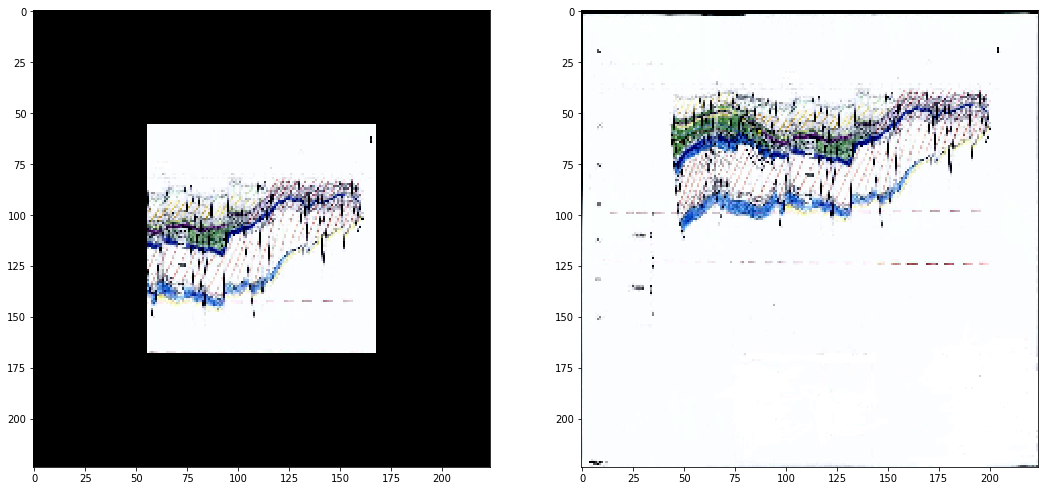

In [1308]:
# Exemple of cropping
PATH =list(cropped_dict.keys())[np.random.randint(0,20)]
n = np.random.randint(0,10)
fig, ax = plt.subplots(1,2,figsize=(18, 10))
ax[0].imshow(cropped_dict[PATH][n])
ax[1].imshow(prepare_image(DIRECTORY+PATH)[0])

In [1302]:
# Create pairs with labels in form [in1,in2], Label

In [1312]:
cropped_dict

{'00132.jpg': [array([[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         ...,
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
  
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0

In [ ]:
def generate_data(cropped_dic):
    return [[x1,x2],label]